In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm
import glob
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import tensorflow as tf
import keras
from keras.layers import Input, Dense, LeakyReLU
from keras.models import Model, Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

import os
import gzip
import sys

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

***
# LCC data import

In [2]:
# Import lcc data files for wt protein and assign to variable (wt_windowsize)

wt_files=glob.glob('w*.lccdata')

window_range = list(range(2,51))
wt_dict = {}
for window, file in zip(window_range, wt_files):
    wt_dict[window] = pd.DataFrame(np.loadtxt(file)).drop(columns=0) 

In [3]:
# Import lcc data files for mutant protein and assign to variable (mutant_windowsize)

m_files=glob.glob('m*.lccdata')

D132H_dict = {}
for window, file in zip(window_range, m_files):
    D132H_dict[window] = pd.DataFrame(np.loadtxt(file)).drop(columns=0)

In [4]:
# Visualization of dataset

print('WT for window size = 5')
display(wt_dict[5])

print('\n')
print('---------------------------------')
print('D132H for window size = 12')
display(D132H_dict[12])

WT for window size = 5


,1,2,3,4,5,6,7,8,9,10,...,56,57,58,59,60,61,62,63,64,65
0,8.4312,9.5361,9.3766,9.2660,9.9433,9.4571,9.6182,10.2676,10.2226,9.7319,...,8.8330,9.4795,13.4022,11.3185,12.1872,12.1484,15.8102,16.4597,15.1450,12.9981
1,8.7916,9.6580,9.6946,9.7889,10.2710,8.7514,9.1729,9.4072,9.8066,9.5092,...,8.7344,9.5236,13.5687,11.1643,12.8380,12.0473,16.2331,17.3571,14.5102,10.3342
2,8.4969,9.7424,9.2856,9.4945,10.2100,9.7501,9.3951,9.3884,9.2633,9.3148,...,11.0931,10.2994,15.4896,10.8769,12.1511,13.8864,10.9804,11.2729,13.8106,10.6559
3,8.3818,10.0616,8.6280,9.6703,10.6699,9.0544,9.7888,10.8737,9.1554,10.2863,...,12.8534,11.7250,16.3966,10.8761,11.9600,9.8509,17.0140,16.5833,14.3633,12.7481
4,7.5196,7.7193,10.1350,9.2006,9.3490,9.1282,9.3450,9.3715,9.5052,10.1185,...,9.0316,12.5238,14.8338,11.1429,12.7329,11.8138,17.1041,15.7779,11.8769,9.4603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,12.8071,14.6277,7.8362,11.2315,10.1866,11.3139,11.8900,11.4303,9.2643,9.5495,...,9.1574,10.5208,9.0648,9.1158,9.0196,9.3991,14.0049,12.2617,12.5114,13.8528
39996,14.6709,14.2225,10.0495,11.3026,10.3176,9.8255,11.8256,14.3835,10.5740,9.4388,...,8.6335,10.1313,10.4076,9.1010,8.7447,12.2108,10.6059,13.9447,14.4282,15.6855
39997,7.7636,12.9550,9.6664,9.1188,9.8602,8.4767,12.6994,13.0659,10.3564,8.5447,...,10.1644,10.8862,10.3117,9.7149,8.5182,10.5723,11.2149,12.8444,14.7079,16.1765
39998,12.8168,13.4219,5.3329,9.3870,9.7755,8.4664,9.9262,12.2373,10.5754,9.1512,...,8.6294,9.0778,11.2838,9.2821,8.2358,9.5664,10.0230,14.7938,15.0607,13.7237




---------------------------------
D132H for window size = 12


,1,2,3,4,5,6,7,8,9,10,...,49,50,51,52,53,54,55,56,57,58
0,17.2544,18.5460,20.2335,17.5743,18.2516,14.9958,14.0890,19.2429,11.3637,10.5668,...,21.9454,17.3618,20.1741,18.5240,21.6507,26.4761,25.3541,21.5266,28.3691,31.9909
1,18.0184,18.1145,19.7908,18.5282,18.4543,15.0499,14.6610,20.4204,13.9534,13.5068,...,19.6793,18.4111,21.3406,18.3380,19.9538,26.1776,25.5083,25.5529,29.0048,28.9661
2,18.6480,19.5519,21.1536,19.6276,19.3310,16.5011,15.5453,20.3391,15.6460,14.0567,...,19.9914,15.5205,17.6850,18.3114,25.2819,22.8756,23.5028,24.4405,27.1894,26.7587
3,17.3058,19.4245,20.3042,18.7338,17.7941,13.6412,13.2863,19.6351,13.9899,14.3771,...,22.3635,22.2206,25.1627,21.0134,24.4350,25.1088,24.5927,26.2216,27.2357,26.8857
4,17.4371,20.2468,21.4620,18.6958,17.7962,16.5941,18.0874,21.9220,13.5241,14.8083,...,18.6782,23.2148,22.5731,19.6743,23.8261,24.6477,24.9682,26.4675,27.2646,27.3087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,20.1262,16.4970,18.7419,18.4391,17.9316,13.3469,6.2733,8.1230,15.3153,12.2602,...,17.7812,19.3003,18.7916,18.3789,18.5789,14.3787,17.7950,11.1164,11.1604,20.3502
39996,18.4461,18.8259,22.7662,22.0188,18.8853,13.3072,6.2535,9.5151,16.5346,11.7140,...,18.4096,20.6778,18.8001,18.3584,17.8929,12.8377,17.5137,11.2960,11.5528,20.8567
39997,20.3085,19.1779,18.9030,18.9518,18.6252,13.4729,6.2951,8.3997,15.3879,11.6195,...,19.4887,19.6447,20.9796,19.1305,18.6703,13.2119,16.3622,10.9929,10.7441,19.3623
39998,21.0826,17.0348,17.7007,18.8354,17.9297,12.8318,5.9919,9.1569,14.9421,11.0831,...,17.7948,20.4257,20.7421,17.5806,19.8371,13.7586,17.4126,11.0054,10.8174,19.8463


***
# 1.3 gzip file compression

In [74]:
# Function for data compression 

def compression(lcc, name):
    
    '''
    generates compressed and uncompressed csv and gzip files 
    (respectively) for each column in the lcc data
    '''
    
    compression_options = {'method': 'gzip', 'compresslevel': 9}

    for col in range(1, len(lcc.columns)):
        lcc.to_csv(path_or_buf=name+'_'+str(col)+".gzip", sep=',', columns=[col], mode='w', compression=compression_options)
    
    for col in range(1, len(lcc.columns)):
        lcc.to_csv(path_or_buf=name+'_'+str(col)+".csv", sep=',', columns=[col], mode='w', compression=None)


In [93]:
# Compression for wild types and mutants

for window in tqdm(window_range):
    compression(wt_dict[window], 'wt_{}'.format(window))
    compression(D132H_dict[window], 'D132H_{}'.format(window))

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [59:09<00:00, 72.43s/it]


In [94]:
# Creates data frame with compression ratio for each aa position 

def ratio_df(lcc, window, name):
    '''
    Creates a data frame of ratios of csv to gzip size at each aa position 
    '''
    
    csv_size = []
    gzip_size = []
    
    ratio = []
    for col in range(1, len(lcc.columns)):
        csv_size = os.path.getsize(name+'_'+str(col)+".csv")
        gzip_size = os.path.getsize(name+'_'+str(col)+".gzip")
        #print("uncompressed = ", csv_size)
        #print("compressed = ", gzip_size)
    
        ratio.append(csv_size/gzip_size)
    
    ratio_df = pd.DataFrame(ratio, columns=[str(window)])
    
    return ratio_df     

In [141]:
# Compression ratios for wild types and mutants

comp_ratio_dict = {}

for window in tqdm(window_range):
    
    df1_cr = ratio_df(wt_dict[window], window, 'wt_{}'.format(window))
    df2_cr = ratio_df(D132H_dict[window], window, 'D132H_{}'.format(window))
    df3_cr = pd.concat([df1_cr, df2_cr], axis=1)
    df3_cr.columns = ['wt', 'mutant']
    comp_ratio_dict[window] = df3_cr
    #comp_ratio_dict[window] = df3_cr.mean(axis=1).values

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 49.87it/s]


In [159]:
# AA positions for plotting
pos = []

for i in tqdm(range(48)):

    upper_limit = 70  - (i+2) # max protein length + 1
    pos.append(np.arange(1 + (i+2) / 2 ,upper_limit + (i+2) / 2) + 90)

100%|███████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 24064.86it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:03<00:00, 12.16it/s]


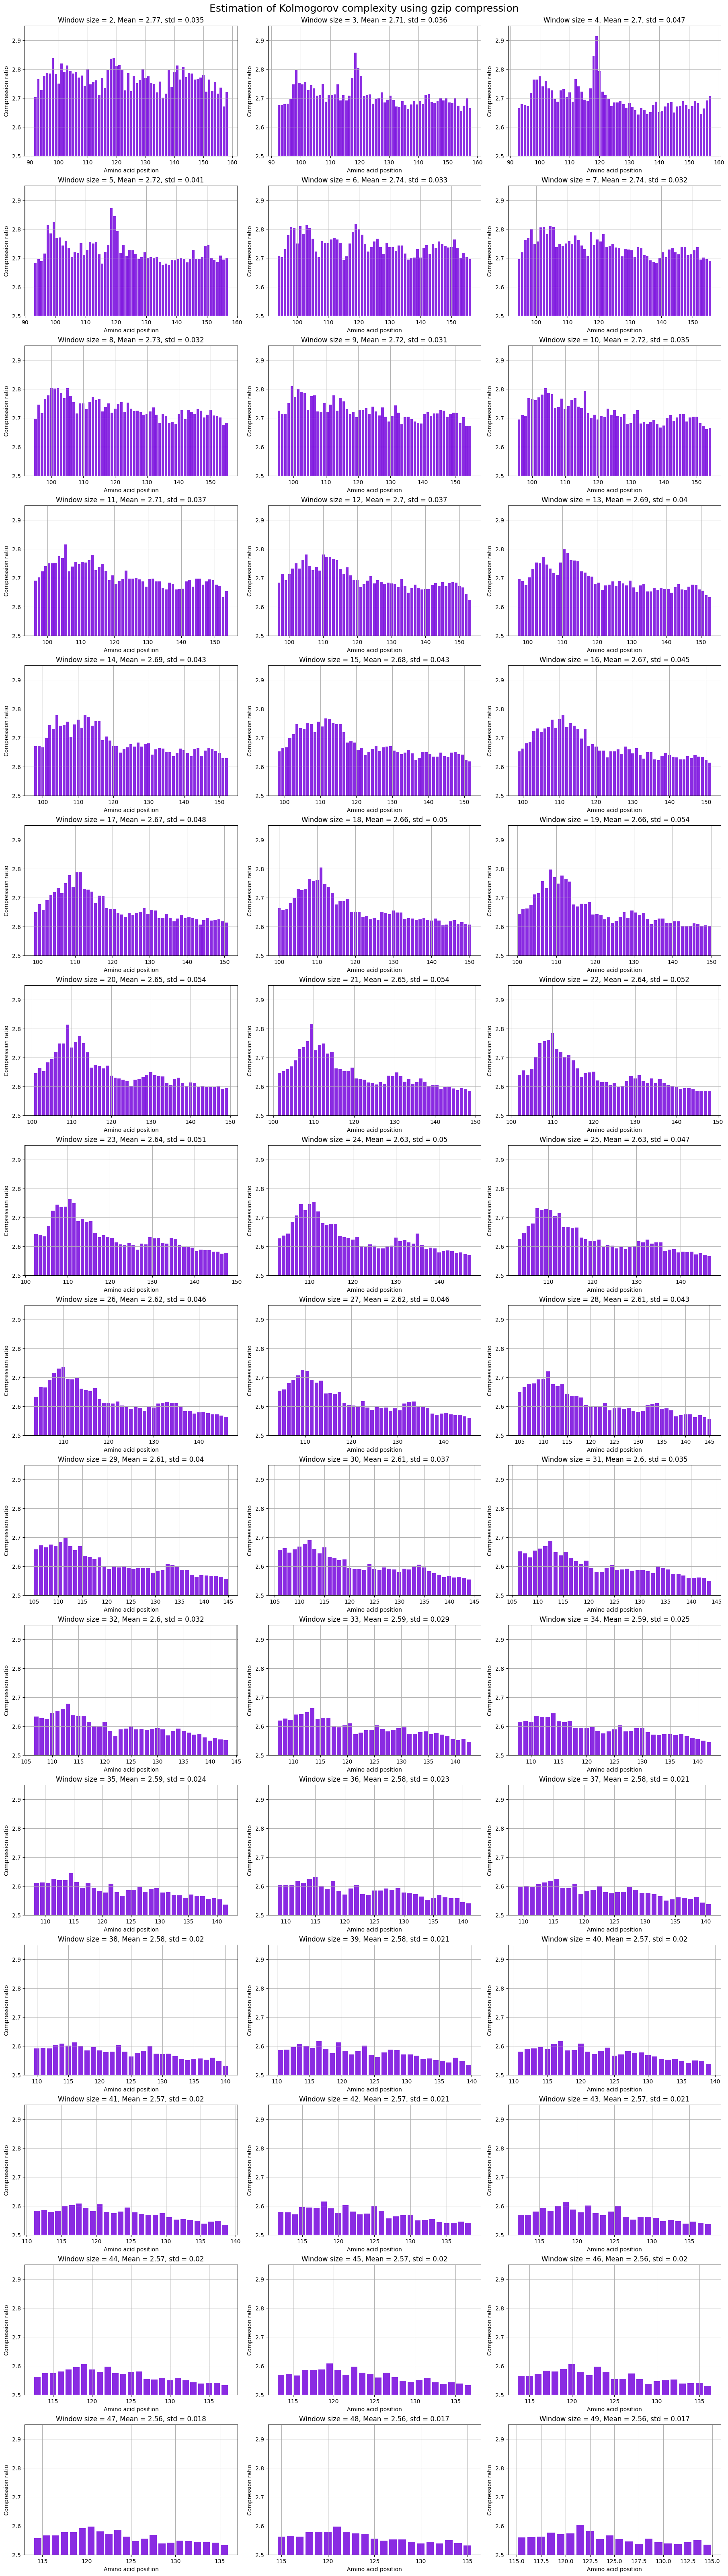

In [174]:
# Plot compression ratios

fig, ax = plt.subplots(16,3, figsize=(18,4*16), constrained_layout=True)

for i in tqdm(range(48)):
    df_pl_ratio_mean = comp_ratio_dict[i+2].mean(axis=1)
    #xx = np.array(df_pl_ratio_mean.index.to_list())
    #upper_limit = 70 + 1 - (i+2) # max protein length + 1
    #pos = np.arange(1 + (i+2) / 2 ,upper_limit + (i+2) / 2) + 90
    yy = np.array(df_pl_ratio_mean.values)
    ax[i//3][i%3].bar(pos[i], yy, color='blueviolet')
    #abs_diff1 = comp_ratio_dict[i+2].iloc[:,0] - comp_ratio_dict[i+2].iloc[:,1]
    #abs_diff2 = abs(abs_diff1.values)
    #ax[i//3][i%3].bar(df_pl_ratio_mean.index.to_list(), abs_diff2, color='lime', alpha=0.6)
    ax[i//3][i%3].grid()
    mean1 = np.mean(yy)
    std1 = np.std(yy)
    ax[i//3][i%3].set_title('Window size = {}, Mean = {}, std = {}'.format(i+2, np.round(mean1,2), np.round(std1,3)))
    ax[i//3][i%3].set_ylim(2.5,2.95)
    ax[i//3][i%3].set_xlabel('Amino acid position')
    ax[i//3][i%3].set_ylabel('Compression ratio')
    
#plt.supylabel("Feature importance")
plt.suptitle("Estimation of Kolmogorov complexity using gzip compression", fontsize=18)
#plt.supxlabel("Position")

plt.show()

Text(0, 0.5, 'Compression ratio')

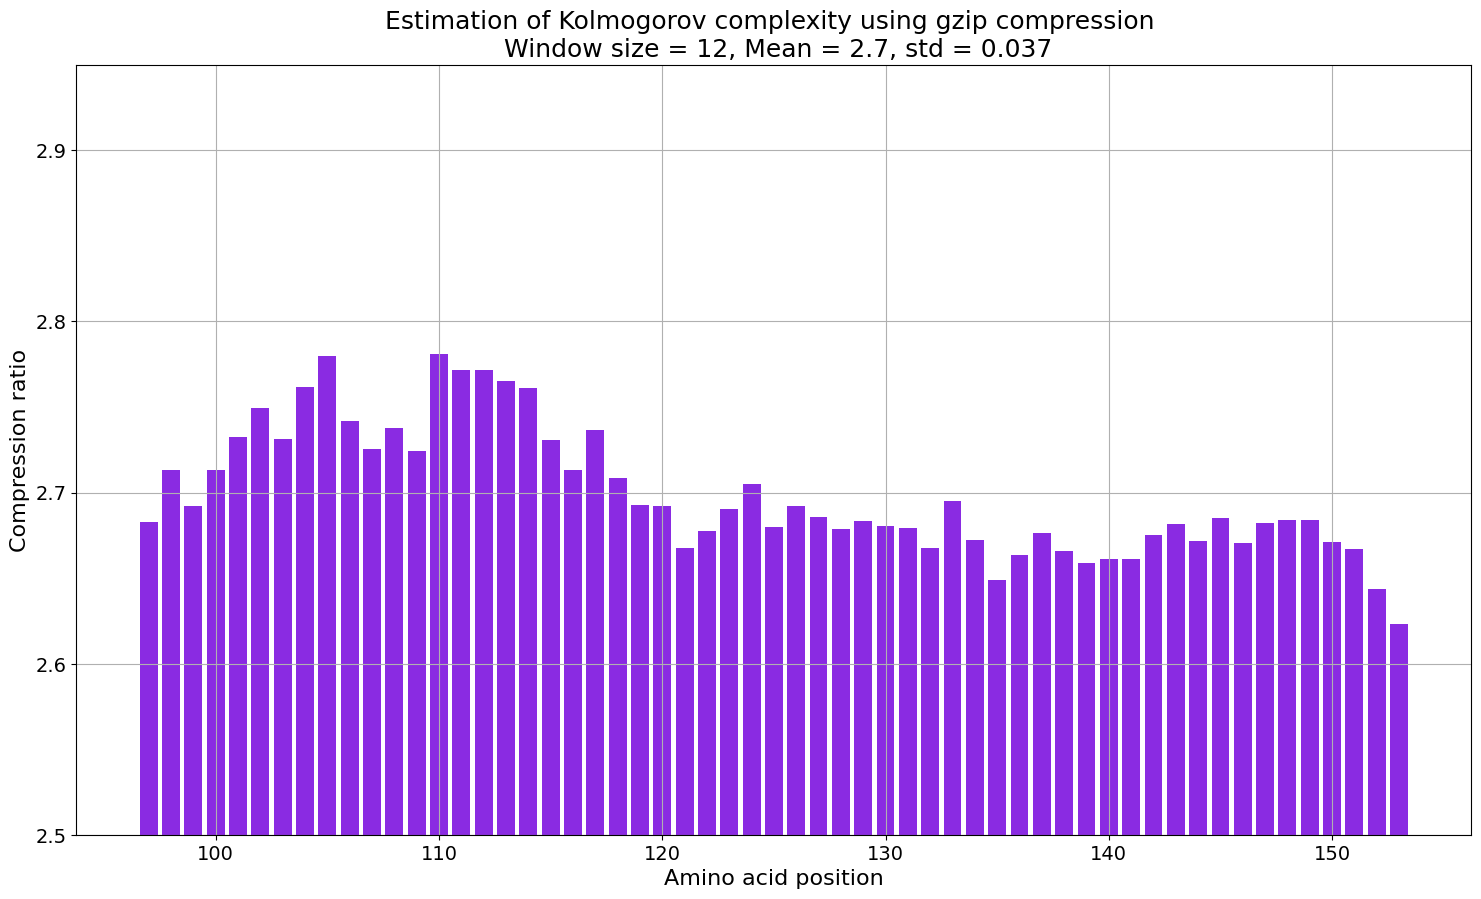

In [179]:
# Plot compression ratios for ws = 12
x1 = pos[10]
df_pl_ratio_mean = comp_ratio_dict[12].mean(axis=1)
y1 = np.array(df_pl_ratio_mean.values)
plt.figure(figsize=(18,10))
plt.bar(x1,y1, color='blueviolet')
plt.title('Estimation of Kolmogorov complexity using gzip compression \n Window size = {}, Mean = {}, std = {}'.format(12, 2.7,0.037), fontsize = 18)
plt.ylim(2.5,2.95)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.xlabel('Amino acid position', fontsize = 16)
plt.ylabel('Compression ratio', fontsize = 16)

Text(0.5, 0, 'Amino acid position')

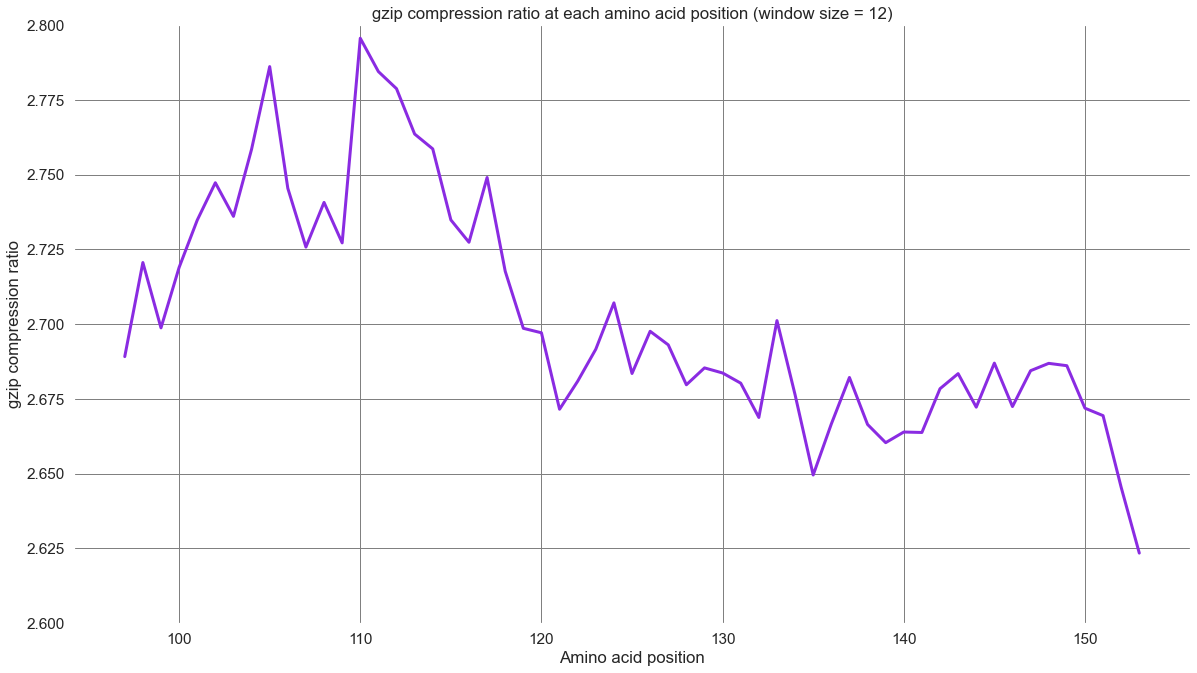

In [216]:
# Plot compression ratios for ws 12 (line graph)
plt.rcParams['font.size'] = '20'

ax=allratios_12.iloc[:,2].plot(use_index=True,title= "gzip compression ratio at each amino acid position (window size = 12)",linewidth=3, ylim=(2.6,2.8), color = 'blueviolet')
ax.set_facecolor('white')
ax.grid(color = 'gray')
plt.ylabel("gzip compression ratio") 
plt.xlabel("Amino acid position")

<AxesSubplot:title={'center':'gzip compression ratio at each amino acid position (window size = 12)'}, xlabel='Amino acid position', ylabel='gzip compression ratio'>

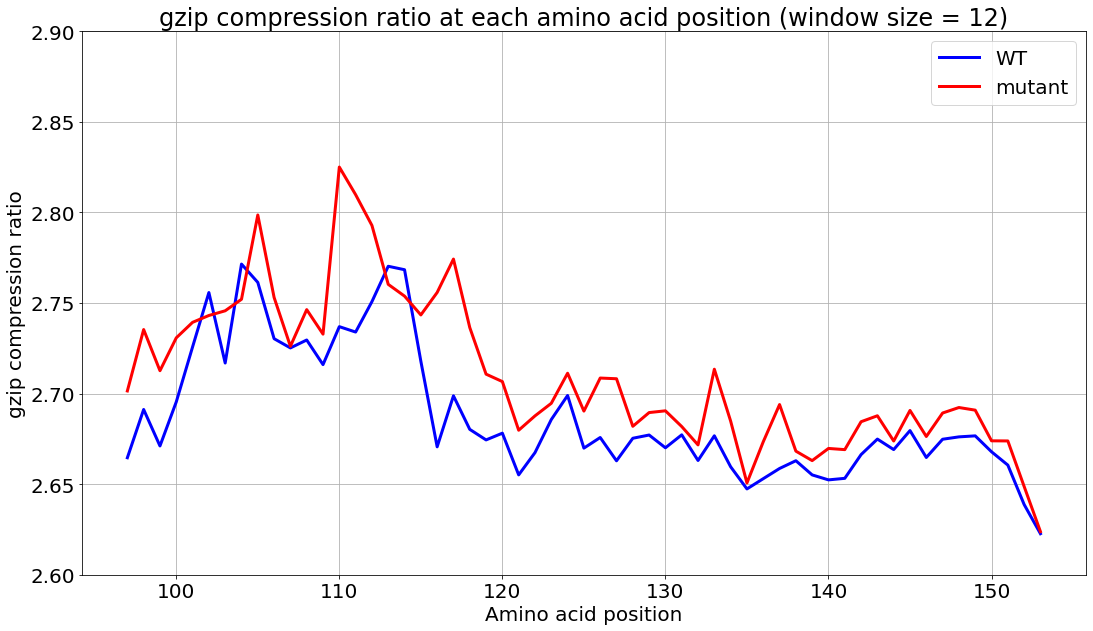

In [154]:
# Plot compression ratios (ws 12) individually for wt and mutant

plt.rcParams['font.size'] = '20'
allratios_12.iloc[:,0].plot(use_index=True,grid = True,xlabel="Amino acid position",color = 'b', linewidth=3, ylim=(2.6,2.9), figsize = (18,10), label="WT",fontsize=20, legend=True)
allratios_12.iloc[:,1].plot(use_index=True,grid = True,title= "gzip compression ratio at each amino acid position (window size = 12)", ylabel="gzip compression ratio", xlabel="Amino acid position",color = 'r', linewidth=3, label="mutant" ,legend=True)